In [2]:
from DataLoader import RedWebDataset , Rescale , RandomCrop , ToTensor
from __future__ import print_function, division
import os
import torch
from skimage import io, transform
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [4]:
# from my utils notebook
def add_to_class(Class):
    """Register them functions"""
    def wrapper(obj):
        # setattr(object, name, value) -> sets the value of the attribute
        setattr(Class ,obj.__name__ , obj)
    return wrapper

In [80]:
class OnlineRedWeb(RedWebDataset):
    def __init__(self, root_dir ,transform=None,N:int=10,sigma:int=0.02):
        super().__init__(root_dir,transform)
        self.N =N
        self.sigma = 0.02

    def __getitem__(self, index):
        # Call the __getitem__ method of the original dataset
        original_item = super(OnlineRedWeb, self).__getitem__(index)

        # Extract necessary information from the original_item
        mono = original_item['mono']
        heat = original_item['heat']

        # Implement online sampling logic here
        height, width = heat.shape
        point_a =[]
        point_b =[]
        labels = []

        for _ in range(self.N):
            i, j = random.randint(0, height-1), random.randint(0, width-1)
            k,l = random.randint(0, height-1), random.randint(0, width-1)

            ga, gb = heat[i, j], heat[k, l]  # Assuming heat is a 2D tensor

            if ga/ gb > 1 + self.sigma:
                label = 1
            elif ga/ gb < 1 - self.sigma:
                label = -1
            else:
                label = 0

            point_a.append((i,j))
            point_b.append((k,l))
            labels.append(label)

        # Update the original_item or create a new dictionary to return
        online_item = {'mono': mono,
                       'heat': heat,
                       'point_a':torch.tensor(point_a),"point_b": torch.tensor(point_b),
                       'labels': torch.tensor(labels)}

        return online_item

In [81]:
@add_to_class(OnlineRedWeb)
def online_collater(batch):
    mono = torch.stack([item['mono'] for item in batch])
    heat = torch.stack([item['heat'] for item in batch])
    point_a = [item['point_a'] for item in batch]
    point_b = [item['point_b'] for item in batch]
    labels = [item['labels'] for item in batch]
    return{'mono': mono, 'heat': heat,
           'point_a':point_a ,"point_b":point_b,
           'labels': labels}


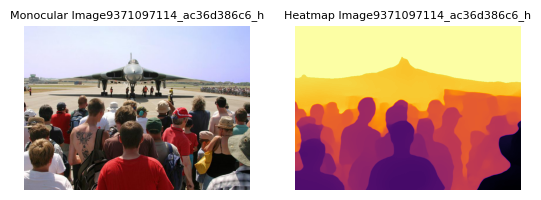

In [82]:
# we can still call the old methods on this class
loader = OnlineRedWeb(root_dir="../ReDWeb_V1")
loader._show_sample()

In [83]:
online_dataset = OnlineRedWeb(root_dir="../ReDWeb_V1",transform=transforms.Compose([
    Rescale(256),
    RandomCrop(225),
    ToTensor()
]))

In [84]:
online_loader = DataLoader(online_dataset,batch_size=32,shuffle=True,collate_fn=custom_collate)

In [86]:
for i, batch in enumerate(online_loader):
    if i > 0 :
        break
    print(batch["mono"].shape)
    print(batch["heat"].shape)
    print(batch["point_a"].shape)
    print(batch["point_b"].shape)
    print(batch["labels"].shape)


torch.Size([32, 3, 225, 225])
torch.Size([32, 225, 225])
torch.Size([32, 10, 2])
torch.Size([32, 10, 2])
torch.Size([32, 10])
